In [0]:
#importing 
import sys, os
import pandas as pd
import numpy as np
import cv2
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/Emotion Recognition'
sys.path.insert(0, path)
os.chdir(path)
#modelpath = './models/model.h5'

In [0]:
num_features = 32
num_classes = 7  
batch_size = 64
epochs = 100
width, height = 48, 48

Dataset Overview

In [5]:
data = pd.read_csv('./fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


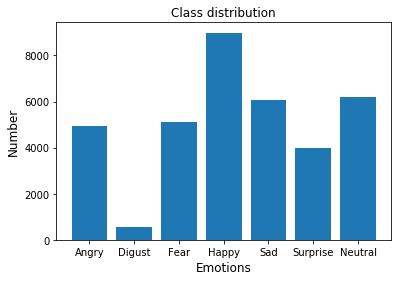

In [7]:
import matplotlib.pyplot as plt
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
plt.bar(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

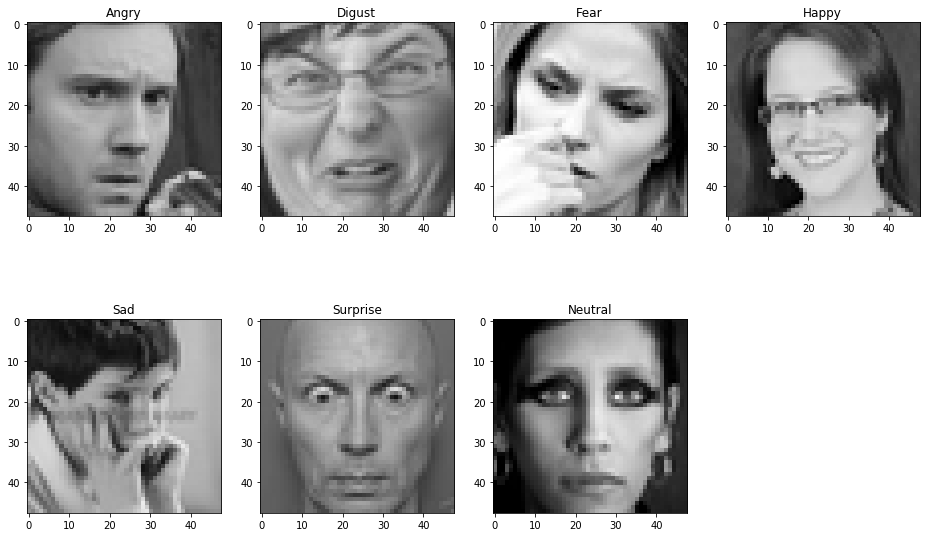

In [8]:
def pxl2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = pxl2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

Pre-processing data

In [0]:
data['pixels'] = data['pixels'].apply(lambda pixel_seq: [int(pixel) for pixel in pixel_seq.split()])

In [10]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training']
data_val   = data[data['Usage']=='PublicTest']
data_test  = data[data['Usage']=='PrivateTest']
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


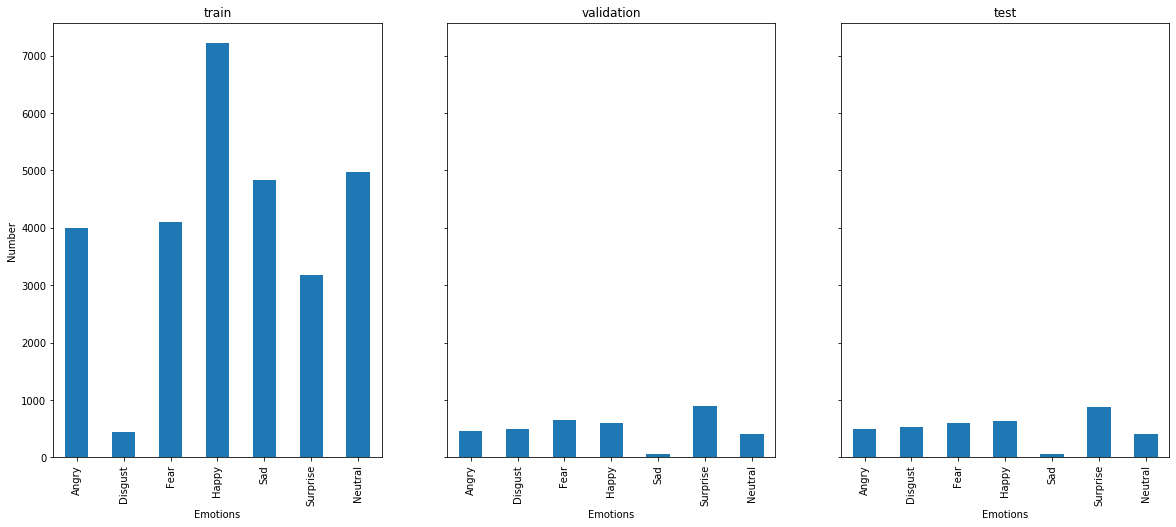

In [11]:
# barplot class distribution of train, val and test data
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    emotion_counts = df['emotion'].value_counts(sort=False)
    emotion_counts.plot(ax=axe, kind='bar')
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
       
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [16]:
#Converting the relevant column element into a list for each row
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def convert(df):
  # training data
  #data_train = data[data['Usage'] == 'Training']
  # reshape image data (num of images, width, height, num of channels)
  x = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width,height,1)/255.0
  # get labels
  y = np_utils.to_categorical(df['emotion'])
  return x,y

# training data
data_train = data[data['Usage'] == 'Training']
x_train, y_train = convert(data_train)

# validation data
data_val = data[data['Usage'] == 'PublicTest']
x_val, y_val = convert(data_val)

# testing data
data_test = data[data['Usage'] == 'PrivateTest']
x_test, y_test = convert(data_test)

print('training data', x_train.shape, y_train.shape)
print('validation data', x_val.shape, y_val.shape)
print('testing data', x_test.shape, y_test.shape)

training data (28709, 48, 48, 1) (28709, 7)
validation data (3589, 48, 48, 1) (3589, 7)
testing data (3589, 48, 48, 1) (3589, 7)


Building CNN Model

In [17]:
model = Sequential()

model.add(Conv2D(64, 3, input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 64)        0 

In [18]:
model.fit(np.array(x_train), np.array(y_train),batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(np.array(x_val), np.array(y_val)),shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 28709 samples, validate on 3589 samples
Epoch 1/100
28709/28709 [==============================] - 15s 508us/step - loss: 1.9611 - acc: 0.2624 - val_loss: 1.5978 - val_acc: 0.3901
Epoch 2/100
28709/28709 [==============================] - 10s 335us/step - loss: 1.6323 - acc: 0.3593 - val_loss: 1.5745 - val_acc: 0.3898
Epoch 3/100
28709/28709 [==============================] - 10s 332us/step - loss: 1.5186 - acc: 0.4097 - val_loss: 1.4395 - val_acc: 0.4327
Epoch 4/100
28709/28709 [==============================] - 10s 331us/step - loss: 1.4431 - acc: 0.4423 - val_loss: 1.4449 - val_acc: 0.4464
Epoch 5/100
28709/28709 [==============================] - 9s 330us/step - loss: 1.3936 - acc: 0.4649 - val_loss: 1.4125 - val_acc: 0.4380
Epoch 6/100
28709/28709 [==============================] - 9s 324us/step - loss: 1.3560 - acc: 0.4740 - val_loss: 1.3982 - val_acc: 0.4572
Epoch 7/100
28709

Saving model 

In [19]:
import joblib
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
print("CNN Error: %.2f%%" % (100-scores[1]*100))
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))
joblib.dump(model, "expression-face.pkl")

3589/3589 [==============================] - 0s 99us/step
CNN Error: 36.58%
Loss: 0.9652651400578058
Accuracy: 0.6341599331622205


['expression-face.pkl']

Evaluate Test Performance

In [25]:
test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(x_test), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)*100))

CNN Model Accuracy on test set: 63.4160
